## **Phase 0 - Data Ingestion, Discovery, and Target Selection**

-The main goals of this notebook are:

- Acquire and extract the ChEMBL dataset for local exploration.
- Perform lightweight schema discovery to examine key tables and viable features.
- Creaate temp df with these potential features and do lightweight EDA, also creating our key target classifying variable here.
- Use SQL-based inspection to determine which compound and target-related data are relevant.
- Narrow the project scope by selecting **a single biological target** to serve as the foundation for all downstream modeling phases.
- Anchor this target selection within the context of treating **epilepsy** based on available compound-disease links.
- Export schema and phase 1 df for future use and reference.

> This phase acts as the bridge between exploratory schema discovery and translational ML scoping. Once the target is selected, the remainder of the pipeline (feature engineering, modeling, interpretation, and repurposing) will operate through this lens.



#### Bash code to download and extract the ChEMBL data to our folder in the project directory.

In [1]:
# downloading the whole dataset
!wget https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_35_sqlite.tar.gz -P ../data/

# extracting the tar file from the download
!tar -xvzf ../data/chembl_35_sqlite.tar.gz -C ../data/


--2025-04-10 11:59:38--  https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_35_sqlite.tar.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4986486022 (4.6G) [application/x-gzip]
Saving to: ‘../data/chembl_35_sqlite.tar.gz’

chembl_35_sqlite.ta 100%[===================>]   4.64G  23.9MB/s    in 4m 23s  

2025-04-10 12:03:54 (18.1 MB/s) - ‘../data/chembl_35_sqlite.tar.gz’ saved [4986486022/4986486022]

chembl_35/chembl_35_sqlite/
chembl_35/chembl_35_sqlite/INSTALL_sqlite
chembl_35/chembl_35_sqlite/chembl_35.db


#### Good, now we will connect to the ChEMBL db using SQLAlchemy and explore the available tables.

In [2]:
from sqlalchemy import create_engine, inspect
import pandas as pd

In [3]:
# Create the db engine
engine = create_engine("sqlite:///../data/chembl_35/chembl_35_sqlite/chembl_35.db")

# Inspect table names
inspector = inspect(engine)
tables = inspector.get_table_names()

print(f"ChEMBL contains {len(tables)} tables:")
print(tables)

ChEMBL contains 79 tables:
['action_type', 'activities', 'activity_properties', 'activity_smid', 'activity_stds_lookup', 'activity_supp', 'activity_supp_map', 'assay_class_map', 'assay_classification', 'assay_parameters', 'assay_type', 'assays', 'atc_classification', 'binding_sites', 'bio_component_sequences', 'bioassay_ontology', 'biotherapeutic_components', 'biotherapeutics', 'cell_dictionary', 'chembl_id_lookup', 'chembl_release', 'component_class', 'component_domains', 'component_go', 'component_sequences', 'component_synonyms', 'compound_properties', 'compound_records', 'compound_structural_alerts', 'compound_structures', 'confidence_score_lookup', 'curation_lookup', 'data_validity_lookup', 'defined_daily_dose', 'docs', 'domains', 'drug_indication', 'drug_mechanism', 'drug_warning', 'formulations', 'frac_classification', 'go_classification', 'hrac_classification', 'indication_refs', 'irac_classification', 'ligand_eff', 'mechanism_refs', 'metabolism', 'metabolism_refs', 'molecule_a

#### Let's go over our Phase 1 focus here, so we can dial into what we might need:

**"Build a machine learning model that predicts compound-target bioactivity, specifically IC50 values, using drug-like chemical structures from ChEMBL."*

#### So looking into that a bit we can start with tables like:
- activities
- compound_structures
- molecule_dictionary
- target_dictionary
- assays
- compound_properties
- molecule_hierarchy
- drug_indication

#### I will just view the first 3 rows to see what our features are and what some of the entries look like to get an idea of what the subject tables contain.


In [7]:
# Spin up subject tables
tables_to_check = [
    "activities",
    "compound_structures",
    "molecule_dictionary",
    "target_dictionary",
    "assays",
    "compound_properties",
    "molecule_hierarchy",
    "drug_indication"
]

# For loop for our table var to read in the top 3 rows
for table in tables_to_check:
    df = pd.read_sql(f"SELECT * FROM {table} LIMIT 3;", engine)
    print(f" {table}")
    display(df)

 activities


,activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,...,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,action_type
0,31863,54505,6424,206172,180094,>,100000,nM,1,IC50,...,None,None,1,IC50,>,100.0,uM,None,None,None
1,31864,83907,6432,208970,182268,=,2500,nM,1,IC50,...,None,None,1,IC50,=,2.5,uM,None,None,None
2,31865,88152,6432,208970,182268,>,50000,nM,1,IC50,...,None,None,1,IC50,>,50.0,uM,None,None,None


 compound_structures


,molregno,molfile,standard_inchi,standard_inchi_key,canonical_smiles
0,1,\n RDKit 2D\n\n 24 26 0 0 0 0...,InChI=1S/C17H12ClN3O3/c1-10-8-11(21-17(24)20-1...,OWRSAHYFSSNENM-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl
1,2,\n RDKit 2D\n\n 25 27 0 0 0 0...,InChI=1S/C18H12N4O3/c1-11-8-14(22-18(25)21-16(...,ZJYUMURGSZQFMH-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1
2,3,\n RDKit 2D\n\n 25 27 0 0 0 0...,InChI=1S/C18H16ClN3O3/c1-10-7-14(22-18(25)21-1...,YOMWDCALSDWFSV-UHFFFAOYSA-N,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1


 molecule_dictionary


,molregno,pref_name,chembl_id,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,first_approval,...,usan_year,availability_type,usan_stem,polymer_flag,usan_substem,usan_stem_definition,indication_class,withdrawn_flag,chemical_probe,orphan
0,1,None,CHEMBL6329,None,0,0,MOL,None,Small molecule,None,...,None,-1,None,0,None,None,None,0,0,-1
1,2,None,CHEMBL6328,None,0,0,MOL,None,Small molecule,None,...,None,-1,None,0,None,None,None,0,0,-1
2,3,None,CHEMBL265667,None,0,0,MOL,None,Small molecule,None,...,None,-1,None,0,None,None,None,0,0,-1


 target_dictionary


,tid,target_type,pref_name,tax_id,organism,chembl_id,species_group_flag
0,1,SINGLE PROTEIN,Maltase-glucoamylase,9606,Homo sapiens,CHEMBL2074,0
1,2,SINGLE PROTEIN,Sulfonylurea receptor 2,9606,Homo sapiens,CHEMBL1971,0
2,3,SINGLE PROTEIN,Phosphodiesterase 5A,9606,Homo sapiens,CHEMBL1827,0


 assays


,assay_id,doc_id,description,assay_type,assay_test_type,assay_category,assay_organism,assay_tax_id,assay_strain,assay_tissue,...,curated_by,src_id,src_assay_id,chembl_id,cell_id,bao_format,tissue_id,variant_id,aidx,assay_group
0,1,11087,The compound was tested for the in vitro inhib...,B,None,None,None,None,None,None,...,Autocuration,1,None,CHEMBL615117,None,BAO_0000019,None,None,CLD0,None
1,2,684,Compound was evaluated for its ability to mobi...,F,None,None,None,None,None,None,...,Autocuration,1,None,CHEMBL615118,None,BAO_0000219,None,None,CLD0,None
2,3,15453,None,B,None,None,None,None,None,None,...,Autocuration,1,None,CHEMBL615119,None,BAO_0000019,None,None,CLD0,None


 compound_properties


,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,...,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score
0,1,341.75,2.11,5,1,84.82,3,N,0,6.48,...,341.75,3,24,0.74,341.0567,C17H12ClN3O3,6,1,0,-1.56
1,2,332.32,1.33,6,1,108.61,3,N,0,6.33,...,332.32,3,25,0.73,332.0909,C18H12N4O3,7,1,0,-1.59
2,3,357.80,2.27,5,2,87.98,3,N,0,6.33,...,357.80,3,25,0.75,357.0880,C18H16ClN3O3,6,2,0,-0.82


 molecule_hierarchy


,molregno,parent_molregno,active_molregno
0,1,1,1
1,2,2,2
2,3,3,3


 drug_indication


,drugind_id,record_id,molregno,max_phase_for_ind,mesh_id,mesh_heading,efo_id,efo_term
0,22606,1390869,675774,2,D045743,"Scleroderma, Diffuse",EFO:0000404,diffuse scleroderma
1,22607,1390869,675774,4,D001172,"Arthritis, Rheumatoid",EFO:0000685,rheumatoid arthritis
2,22609,1343491,675576,3,D009203,Myocardial Infarction,EFO:0000612,myocardial infarction


#### Alright looks like we have some good candidates for features to get started for phase 1.  
- In **activities** standard_value will be the target for this phase, and I need to make sure its filterd by IC50.  I will also want to grab the molregno feature since its going to be join glue.

- In **compound_structures** we will want canonical_smiles feature, as this is super important for defining the molecular structure's identity.  This is one of the most critical features that could have been found.  Also I will be using molregno for joins.

- In **molecule_dictionary** I will look to take max_phase and molecule_type, while not as mandatory they both will be important when going to filter our dataframe down and reducing noise.

- In **target_dictionary** I want to grab two really important modifying features in organism and target_type.  These two will really help reduce noise and filter down our data, helping increase our output later on.

- In **assays** I will be looking to use assay_type and confidence_score for more filtering.

- In **compound_properties** I will use the default QSAR features contained (mw_freebase, alogp, hba, hbd, psa, rtb, qed_weighted, aromatic_rings) and upon our query I will for Phase 1 use the Lipinski Filter on the appropriate features.

- In **molecule_hierarchy** I don't see anything that I need at this time.

- In **drug_indication**, we identify the set of scoped subject molecules (compounds) associated with Epilepsy.

  

#### Before proceeding into target scoping, I want to build a temporary working dataframe that includes several of the key features we've identified. This will allow us to explore how they interact and behave, and to define our binary target label (`active`) for Phase 1 modeling.

We'll conduct a lightweight EDA focused on:
- The distribution of IC50 values
- Initial class balance after thresholding IC50 at 1000 nM
- Physicochemical feature behavior (e.g., molecular weight, polarity, hydrogen bonding)

This step is critical to ensure that our features are both sensible and stable before committing to target-specific modeling.

In [18]:
# Make the temp df that involves some of the features we noted above, as well as filtering based on our phase 1 goals.

query_eda = """
SELECT
    a.molregno,
    a.standard_value,
    ass.confidence_score,
    cp.mw_freebase,
    cp.alogp,
    cp.hba,
    cp.hbd,
    cp.rtb,
    cp.qed_weighted,
    td.organism,
    td.target_type
FROM activities a
JOIN assays ass ON a.assay_id = ass.assay_id
JOIN compound_properties cp ON a.molregno = cp.molregno
JOIN target_dictionary td ON ass.tid = td.tid
WHERE a.standard_type = 'IC50'
  AND a.standard_value IS NOT NULL
  AND a.standard_units = 'nM'
  AND ass.assay_type = 'B'
  AND ass.confidence_score IS NOT NULL
  AND td.organism = 'Homo sapiens'
LIMIT 10000
"""
eda_df = pd.read_sql(query_eda, engine)
eda_df['active'] = (eda_df['standard_value'] <= 1000).astype(int) # Using 1000nM as a standard starting filter

print(eda_df.head(10))

   molregno  standard_value  confidence_score  mw_freebase  alogp  hba  hbd  \
0    180094        100000.0                 8       312.33   5.30  4.0  0.0   
1    182268          2500.0                 8       398.37   4.30  5.0  1.0   
2    182855          9000.0                 8       520.50   5.68  7.0  1.0   
3    100708            29.4                 8       324.42   3.19  4.0  2.0   
4    676706          1000.0                 8       428.54   4.51  5.0  1.0   
5     97517          9800.0                 8       342.45   3.37  4.0  0.0   
6     97517          5600.0                 8       342.45   3.37  4.0  0.0   
7     97517            20.0                 8       342.45   3.37  4.0  0.0   
8      6879            45.0                 8       499.51   4.64  5.0  4.0   
9      6879             6.9                 9       499.51   4.64  5.0  4.0   

   rtb  qed_weighted      organism     target_type  active  
0  2.0          0.44  Homo sapiens  SINGLE PROTEIN       0  
1  3.0  

In [10]:
# Quick view at our new target distribution
print(eda_df['active'].value_counts())

active
1    5602
0    4398
Name: count, dtype: int64


#### Looks good, since we took a clean 10k sample row size limit, we can easily ascertain our class balance from the value count call.  56/43 puts us in great shape going forward.  Let's keep going.

count    1.000000e+04
mean     4.047375e+14
std      2.324651e+16
min      8.000000e-03
25%      3.000000e+01
50%      6.500000e+02
75%      1.000000e+04
max      1.621810e+18
Name: standard_value, dtype: float64


<Axes: xlabel='standard_value', ylabel='Count'>

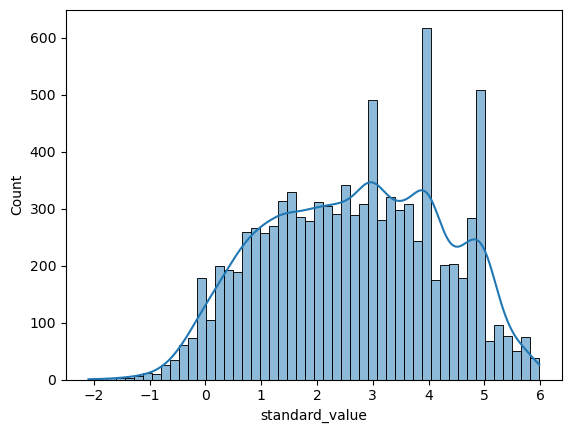

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Show distribution of IC50 values
print(eda_df['standard_value'].describe()) # Massive outlier here, need to set cap to prevent plot from showing distortion in values
clean_ic50 = eda_df['standard_value']
clean_ic50 = clean_ic50[(clean_ic50 > 0) & (clean_ic50 < 1e6)] # Hard cap on values to correct

# Plot distribution
sns.histplot(np.log10(clean_ic50), bins=50, kde=True)



#### This plot does a good job of reaffirming our filter for our target variable in 'active', where we filtered IC50 values at <= 1000.  Since we performed log10 operation on this plot, log10(1000 for our max value for the filter) = 3.0, which is right around the middle. However, there is room for improvement with our filter!  While we initially used 1000nM as a base, we can see in the above that the tail doesn't start to show until ~standard_value = 3.75.  To be safe I can augment the filter to be 3.5 = ~3162nM (undoing the log, which is (10 ** 3.5).  This just increased the amount of data we will be able to retain when we create our phase 1 df, just from 1 plot.  Let's edit our active variable.

In [17]:
eda_df['active'] = (eda_df['standard_value'] <= 3162).astype(int) 

#### Now let's look at some plots involving our QSAR features with our target.

We focus on six well-established physicochemical descriptors derived from ChEMBL’s `compound_properties` table. These are commonly used in early-stage QSAR modeling and have relevance for compound filtering, potency, and drug-likeness.

In [20]:
# Variable that contains our qsar features
qsar_cols = [
    'mw_freebase',
    'alogp',
    'hba',
    'hbd',
    'rtb',
    'qed_weighted'
]
   

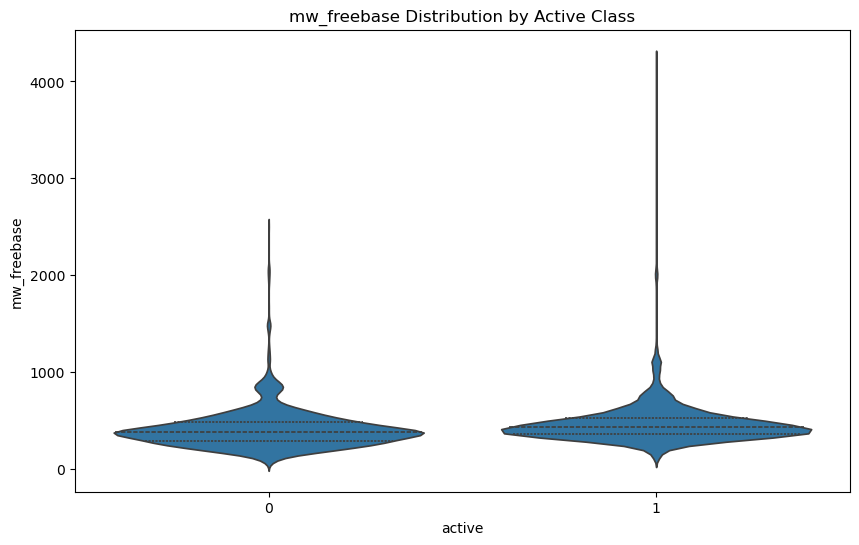

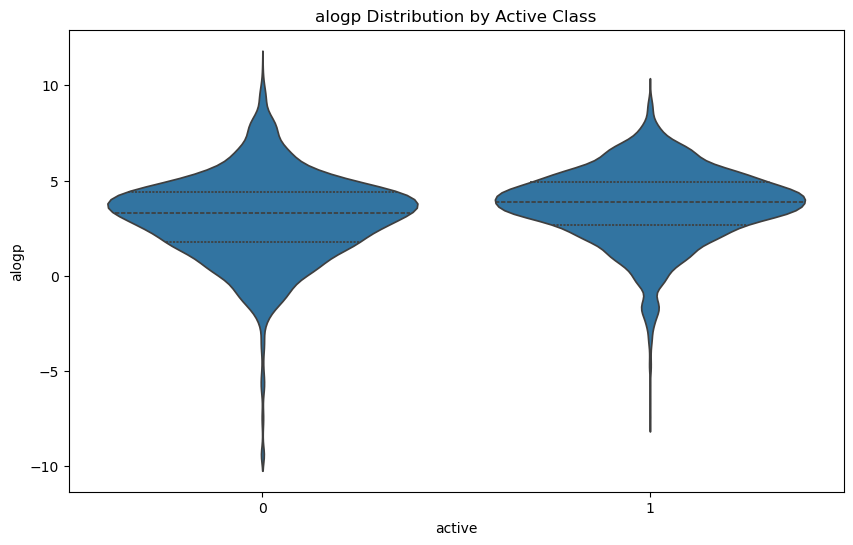

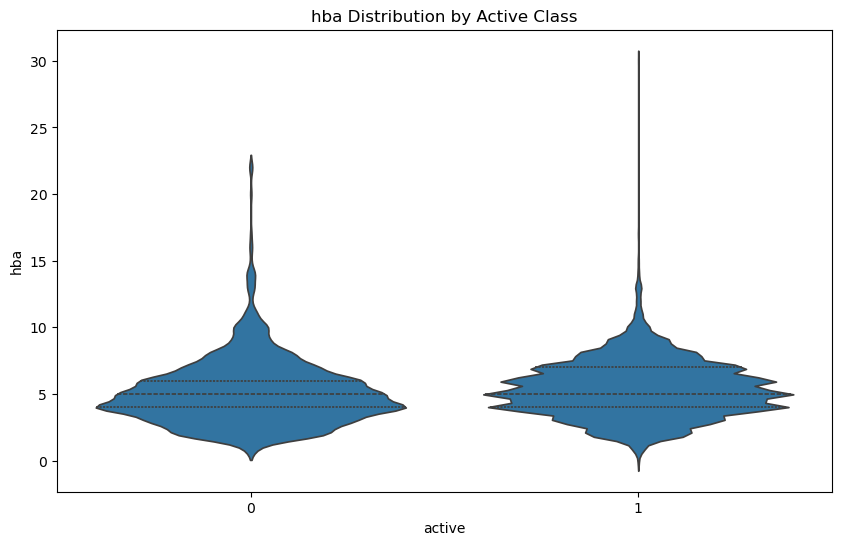

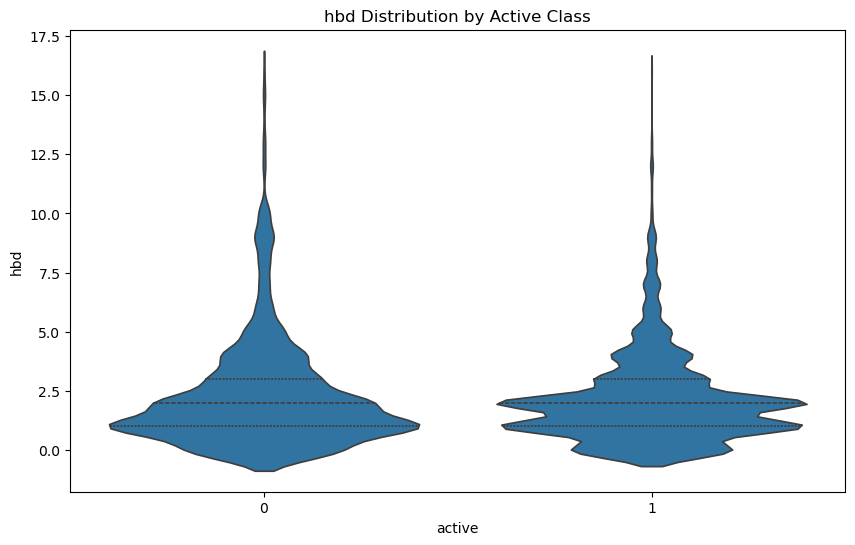

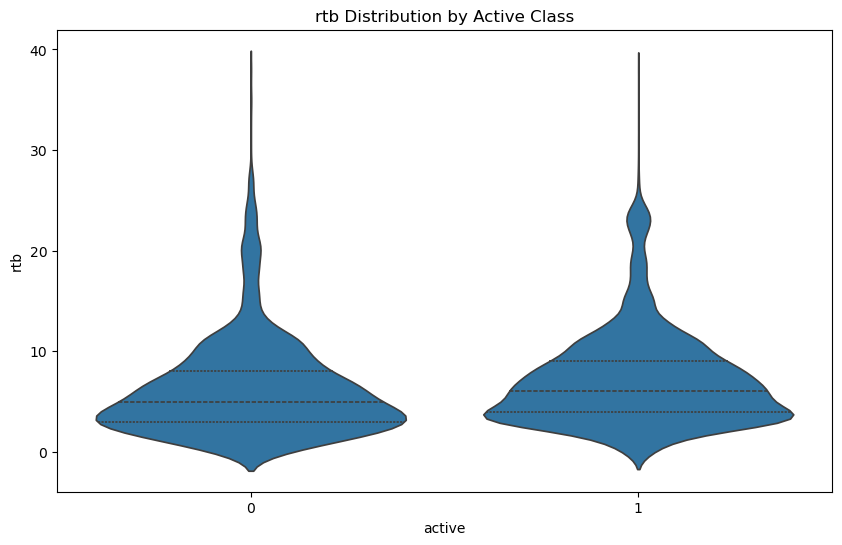

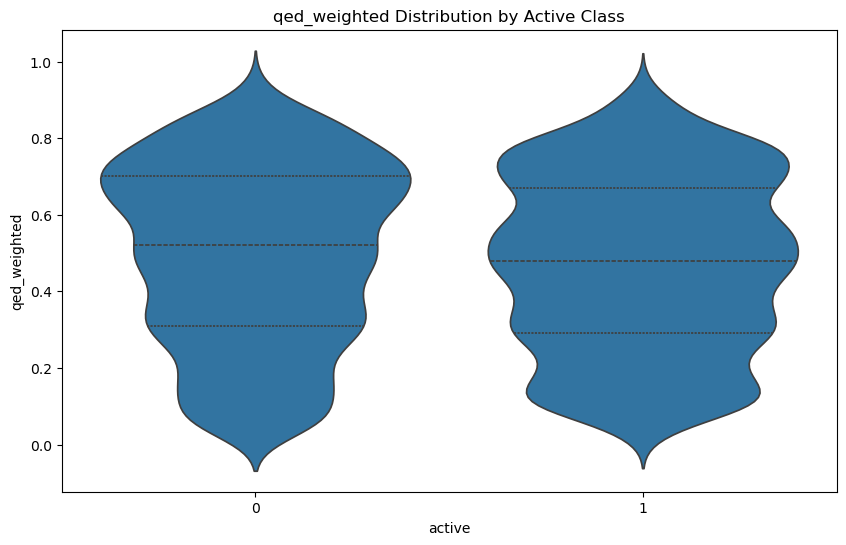

In [23]:
# violin plots for feature distribution
for col in qsar_cols:
    plt.figure(figsize = (10, 6))
    sns.violinplot(data = eda_df, x = 'active', y = col, inner = 'quartile', density_norm = 'width')
    plt.title(f'{col} Distribution by Active Class')
    plt.show()

#### So in the above we see little to no variance in the above plots.  This tells us that the QSAR features aren't very powerful predictors for our target at this time in the subject model.  What this also means is that we will not need to perform any advanced filtering such as the Lipinski filter (was planned) on these features when we go to query the final version of this data for phase 1, as since the QSAR features have shown to be of low significance doing a large filter on them would be just removing data for no reason.

#### We will still keep these features in the dataset for now, however we will look to use RDKit in our forthcoming Feature Engineering notebook to create new features to add to what we have.  At this point no further exploration of these features is necessary, as since there is little to no correlation with the target we don't need to perform any further plotting to confirm this.

#### Now I will look further into to the drug_indication table, scoping in to see what compounds exist involving the treatment of Epilepsy so that we can get closer to identifying our target.

In [26]:
# Load unique values for the efo_term column in the drug_indication table
df_indications = pd.read_sql("SELECT * FROM drug_indication", engine)
pd.DataFrame(sorted(df_indications['efo_term'].dropna().unique()), columns = ['efo_term'])


,efo_term
0,22q11.2 deletion syndrome
1,"ACTH Syndrome, Ectopic"
2,AIDS
3,AIDS dementia
4,AIDS related complex
...,...
2403,wound healing
2404,wrist fracture
2405,xeroderma pigmentosum
2406,xerostomia


In [27]:
# Search through this new df for viable Epilepsy-related contents
epilepsy_terms = df_indications[
    df_indications['efo_term'].str.lower().str.contains('epilep|seizure|convuls', na=False)
][['molregno', 'mesh_heading', 'efo_term']].drop_duplicates()

print(f"Epilepsy-related rows: {len(epilepsy_terms)}")
epilepsy_terms.head(10)


Epilepsy-related rows: 268


,molregno,mesh_heading,efo_term
141,15086,Epilepsy,epilepsy
142,15086,"Epilepsies, Partial",partial epilepsy
275,139940,Epilepsy,epilepsy
276,139940,"Epilepsies, Partial",partial epilepsy
289,31811,Epilepsy,epilepsy
391,38727,Epilepsy,epilepsy
487,139014,Epilepsy,epilepsy
488,139014,Seizures,Seizure
514,685974,Epilepsy,epilepsy
515,685974,Seizures,Seizure


#### 268 rows isn't bad, but we need to keep going.  Let's see how we can take this list and end up with one singular result for our end target.

In [28]:
# First deduplicate, as we can already see there's several just in our head() call above.
epilepsy_mols = epilepsy_terms['molregno'].drop_duplicates()

print(f" Epilepsy-related rows: {len(epilepsy_mols)}")
epilepsy_mols.head(10)

 Epilepsy-related rows: 137


141     15086
275    139940
289     31811
391     38727
487    139014
514    685974
518       921
535    136161
580    675705
643    366279
Name: molregno, dtype: int64

### Now we need a sql query(ies) that helps enhance our target discovery further.  We will introduce several of the feature filters we discussed above.

In [29]:
# Format the IDs for SQL
molregno_str = ','.join(map(str, epilepsy_mols.tolist()))

# Query to get activity and target data with filters
query = f"""
SELECT a.molregno, a.standard_value, a.standard_type, a.standard_units,
    ass.tid AS target_id, ass.confidence_score,
    td.pref_name, td.target_type, td.organism
FROM activities a
JOIN assays ass ON a.assay_id = ass.assay_id
JOIN target_dictionary td ON ass.tid = td.tid
WHERE a.molregno IN ({molregno_str})
    AND a.standard_type = 'IC50'
    AND a.standard_value IS NOT NULL
    AND ass.confidence_score >= 7
    AND td.target_type = 'SINGLE PROTEIN'
    AND td.organism = 'Homo sapiens'
"""

epilepsy_target_data = pd.read_sql(query, engine)

In [30]:
print(f" Returned rows: {len(epilepsy_target_data)}")

 Returned rows: 1118


In [31]:
query_tid_check = f"""
SELECT COUNT(*) as ic50_with_targets
FROM activities a
JOIN assays ass ON a.assay_id = ass.assay_id
WHERE a.molregno IN ({molregno_str})
  AND a.standard_type = 'IC50'
  AND a.standard_value IS NOT NULL
  AND ass.tid IS NOT NULL
"""
pd.read_sql(query_tid_check, engine)


,ic50_with_targets
0,3650


In [32]:
query_target_type_check = f"""
SELECT COUNT(*) as single_protein_targets
FROM activities a
JOIN assays ass ON a.assay_id = ass.assay_id
JOIN target_dictionary td ON ass.tid = td.tid
WHERE a.molregno IN ({molregno_str})
  AND a.standard_type = 'IC50'
  AND a.standard_value IS NOT NULL
  AND td.target_type = 'SINGLE PROTEIN'
"""
pd.read_sql(query_target_type_check, engine)

,single_protein_targets
0,1478


In [33]:
query_preview = f"""
SELECT td.pref_name, COUNT(*) as n_rows
FROM activities a
JOIN assays ass ON a.assay_id = ass.assay_id
JOIN target_dictionary td ON ass.tid = td.tid
WHERE a.molregno IN ({molregno_str})
  AND a.standard_type = 'IC50'
  AND a.standard_value IS NOT NULL
GROUP BY td.pref_name
ORDER BY n_rows DESC
LIMIT 10
"""
pd.read_sql(query_preview, engine)

,pref_name,n_rows
0,Unchecked,373
1,SARS-CoV-2,167
2,No relevant target,147
3,GABA-A receptor; anion channel,105
4,NON-PROTEIN TARGET,97
5,Bile salt export pump,95
6,Carbonic anhydrase II,88
7,Radical scavenging activity,79
8,Carbonic anhydrase IX,71
9,GABA transporter 1,67


#### So we just used our molregno_str within a few queries to make sure we are narrowing our focus to a singular target or tid.  We need to keep going though.  The result above that is most relevant to our desired target in Epilepsy research is 'GABA-A receptor; anion channel', and you can also see that some of the results eliminate themselves.

In [34]:
# Query to filter for tid's associated with GABA-A
query_gabaa_tids = """
SELECT DISTINCT tid, pref_name
FROM target_dictionary
WHERE LOWER(pref_name) LIKE '%gaba-a%'
"""

pd.read_sql(query_gabaa_tids, engine)

,tid,pref_name
0,104291,GABA-A receptor; GABA-A site (alpha1/beta2 int...
1,104301,GABA-A receptor; anion channel
2,104688,GABA-A receptor; anion channel
3,104689,GABA-A receptor; anion channel
4,104702,GABA-A receptor; alpha-3/beta-3/gamma-2
5,104703,GABA-A receptor; alpha-1/beta-3/gamma-2
6,104704,GABA-A receptor; alpha-5/beta-3/gamma-2
7,104712,GABA-A receptor; alpha-2/beta-3/gamma-2
8,104715,GABA-A receptor; anion channel
9,104752,GABA-A receptor; alpha-1/beta-2/gamma-2


#### We are getting there!  Now we have a decision to make though, a fork in the road if you will.  If we select and keep all of these we will have a large comprehensive dataset.  If we pick a few tids, i.e. just the ones with "anion channel" in them then it will be more specific and will be more interpretable though we will have fewer compounds.  Even moreso if we pick just 1 tid from the list above, we can get super-specific and make very clear insights about it.  However, this will result in a much smaller dataset.

#### I will opt for a larger dataset here, choosing all tid's that contain the originally-desired 'GABA-A receptor' as well as 'anion channel', eschewing any unique derivatives.  This will give us a great generalized dataset to work off of for modeling.

In [37]:
# make a df from our previous query
gabaa_tids_df = pd.read_sql(query_gabaa_tids, engine)

# Filter based on the name content so we get what we need (just removing the lone nematode entry)
filtered_tids = [tid for tid in gabaa_tids_df['tid'] if tid != 106176]

In [38]:
print(filtered_tids)

[104291, 104301, 104688, 104689, 104702, 104703, 104704, 104712, 104715, 104752, 104757, 104774, 104904, 104905, 106003, 106004, 117721, 117727, 120117, 121125]


#### Great now we run another query, this time ready for phase 1.  This will include our filtered_tids and all of our discussed and used filters, although we will save some for later like the Lipinksi filter for the QSAR features in a little bit.

In [39]:
query_phase1_final = f"""
SELECT
    a.molregno,
    a.standard_value,
    a.standard_type,
    a.standard_units,
    cs.canonical_smiles,
    cp.mw_freebase,
    cp.alogp,
    cp.hba,
    cp.hbd,
    cp.rtb,
    cp.qed_weighted
FROM activities a
JOIN assays ass ON a.assay_id = ass.assay_id
JOIN molecule_dictionary md ON a.molregno = md.molregno
JOIN compound_structures cs ON a.molregno = cs.molregno
JOIN compound_properties cp ON a.molregno = cp.molregno
WHERE ass.assay_id IN (
    SELECT assay_id FROM assays
    WHERE tid IN ({','.join(map(str, filtered_tids))})
)
    AND a.standard_type = 'IC50'
    AND a.standard_value IS NOT NULL
    AND a.standard_units = 'nM'
    AND ass.assay_type = 'B'
    AND md.molecule_type = 'Small molecule'
"""

In [40]:
phase1_df = pd.read_sql(query_phase1_final, engine)

#  Sanity check, drop any rows with potential missing SMILES data
phase1_df = phase1_df.dropna(subset = ['canonical_smiles'])


In [45]:
# Recreate our active variable for phase 1
phase1_df['active'] = (phase1_df['standard_value'] <= 3162).astype(int) 

# Quick view at our new target distribution
print(phase1_df['active'].value_counts())

active
1    1968
0     882
Name: count, dtype: int64


#### 69/31 class balance with our new nM threshold, not completely out of bounds and we can manage in modeling with the class_weight = 'balanced' param.   

In [47]:
print(phase1_df.shape)

(2850, 12)


In [48]:
print(phase1_df.head(10))

   molregno  standard_value standard_type standard_units  \
0   1634114            0.74          IC50             nM   
1    942456            1.00          IC50             nM   
2   1633993      1000000.00          IC50             nM   
3   1633991            0.68          IC50             nM   
4   1634151            3.70          IC50             nM   
5   1633990         1000.00          IC50             nM   
6   1633994           52.30          IC50             nM   
7      9842            5.00          IC50             nM   
8       721           20.60          IC50             nM   
9      7395            0.50          IC50             nM   

                                    canonical_smiles  mw_freebase  alogp  hba  \
0               O=c1c2cnc3cccc(O)c3c2[nH]n1-c1ccccc1       277.28   2.57  4.0   
1      CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC       390.44   4.62  5.0   
2      O=c1c2cnc3cccc(OCc4ccccc4)c3c2[nH]n1-c1ccccc1       367.41   4.45  4.0   
3            CO

In [50]:
# Close connection
engine.dispose()

#### Great, we have a solidified and focused df now to move forward to our the next step.  We have done the following in this notebook as a summary:

- Acquired and extracted the ChEMBL dataset to use for this project
- Discovered and examined appropriate tables and features relevant to this phase, and potentially beyond.
- Looked into and verified our 'active' target variable threshold, adjusting based on findings.
- Plotted QSAR features against our target, finding little correlation.
- Scoped in and filtered out our target tids (target_ids) relating to our desired Epilepsy target compound.
- Used this list to query with filters from the previously-found and desired features, to formulate a new dataframe for Phase 1.
- Stored the schema in data folder for reference use, as we will need to view it as we pursue the rest of this project.

In [49]:
# Save our phase 1 df to csv for easy recall
phase1_df.to_csv("/home/ryanm/BioPred_DS/data/processed/phase1_df.csv", index = False)